In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "drive/MyDrive/Colab Notebooks/mest"

/content/drive/MyDrive/Colab Notebooks/mest


# Библиотеки

In [3]:
import os
import pickle
from collections import defaultdict

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set_theme()

import torch

from tqdm.notebook import tqdm as tqdm_n
from tqdm import tqdm
from functools import partial
from time import gmtime, strftime, time

from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from torchvision.transforms import v2
from torchvision.utils import save_image

In [4]:
ls

demo.ipynb             logs/          Zhukovsky/  КККМ_bin.zip              КККМfolder9_bin/
kraken_example2.ipynb  Potanin.ipynb  КККМ/       КККМfolder3_bin/
kraken_example.ipynb   weights/       КККМ_bin/   КККМfolder3_strokes_bin/


# MNIST

In [5]:
# !pip install kagglehub

In [6]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("hojjatk/mnist-dataset")

# print("Path to dataset files:", path)

In [7]:
# !ls /home/natalkaser/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1

In [8]:
# !mv "{path}" .

In [9]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

# #
# # MNIST Data Loader Class
# #
# class MnistDataloader(object):
#     def __init__(self, training_images_filepath,training_labels_filepath,
#                  test_images_filepath, test_labels_filepath):
#         self.training_images_filepath = training_images_filepath
#         self.training_labels_filepath = training_labels_filepath
#         self.test_images_filepath = test_images_filepath
#         self.test_labels_filepath = test_labels_filepath

#     def read_images_labels(self, images_filepath, labels_filepath):
#         labels = []
#         with open(labels_filepath, 'rb') as file:
#             magic, size = struct.unpack(">II", file.read(8))
#             if magic != 2049:
#                 raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
#             labels = array("B", file.read())

#         with open(images_filepath, 'rb') as file:
#             magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
#             if magic != 2051:
#                 raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
#             image_data = array("B", file.read())
#         images = []
#         for i in range(size):
#             images.append([0] * rows * cols)
#         for i in range(size):
#             img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
#             img = img.reshape(28, 28)
#             images[i][:] = img

#         return images, labels

#     def load_data(self):
#         x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
#         x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
#         return (x_train, y_train),(x_test, y_test)


In [10]:
# input_path = '1'
# training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
# training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
# test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
# test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')


# mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
# (x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
# print(len(x_train), len(x_test))

# def dataset2folder(x, y, name):
#     !rm -r "$name"

#     os.makedirs(name, exist_ok=True)

#     cls2counter = defaultdict(int)

#     for i in range(len(x)):
#         image = np.array(x[i])
#         cls = y[i]

#         os.makedirs(f"{name}/{cls}", exist_ok=True)

#         new_name = f"{name}/{cls}/{cls2counter[cls]}.png"
#         if os.path.exists(new_name):
#             raise TypeError

#         # print(new_name)
#         cv2.imwrite(new_name, image)
#         cls2counter[cls] += 1

#     print(cls2counter)



# dataset2folder(x_train, y_train, "MNIST/train")
# dataset2folder(x_test, y_test, "MNIST/test")

In [11]:
# !rm -r 1

# My_Dataset

In [12]:
# https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

class My_Dataset(Dataset):
    def __init__(self, folder, transform):
        super().__init__()

        self.folder = folder
        self.transform = transform

        self.dir_names = sorted(os.listdir(folder)) # ["000" , "001", ...]
        self.num_cls = len(self.dir_names)

        self.dir2cls = {dir : i for i, dir in enumerate(self.dir_names)}
        self.cls2dir = {cls : dir for dir, cls in self.dir2cls.items()}

        self.dataset = [] # список всех путей до изображений
        # image_idx = 0

        self.cls2paths = defaultdict(list) # по cls получить все изображения класса

        for dir in self.dir_names:
            dir_path = os.path.join(folder, dir)

            for i in sorted(os.listdir(dir_path)):
                image_path = os.path.join(dir_path, i)
                cls = self.dir2cls[dir]

                self.dataset.append((image_path, cls))
                self.cls2paths[cls].append(image_path)
                # image_idx += 1

        self.cls2count = {cls : len(idxs) for cls, idxs in self.cls2paths.items()}
        self.dir2count = {self.cls2dir[cls] : count for cls, count in self.cls2count.items()}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, cls = self.dataset[idx]

        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        return image, cls


class My_TripletDataset(My_Dataset):

    def __getitem__(self, idx):
        anchor_path, cls = self.dataset[idx]
        anchor = self.transform(Image.open(anchor_path).convert("RGB"))

        positive_path = random.choice(self.cls2paths[cls])
        positive = self.transform(Image.open(positive_path).convert("RGB"))

        negative_cls = random.choice([i for i in range(self.num_cls) if i != cls])
        negative_path = random.choice(self.cls2paths[negative_cls])
        negative = self.transform(Image.open(negative_path).convert("RGB"))

        return anchor, positive, negative

# Functions

In [13]:
def test_pipeline(model, dataset, collate_fn, device, batch_size):

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    for batch in loader:
        X_batch, y_batch = batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        output = model(X_batch) # torch.Size([BATCH, NUM_CLS])
        print(f"X_batch: {X_batch.shape}\ny_batch: {y_batch.shape}\nmodel:   {output.shape}")
        break


def create_model(model, num_freeze_layers, num_out_classes):
    # замена последнего слоя сети
    model.fc = nn.Linear(512, num_out_classes)

    # заморозка слоев
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model


def save_logs(logs, path):
    with open(path, "wb") as f:
        pickle.dump(logs, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_logs(path):
    with open(path, "rb") as f:
        logs = pickle.load(f)

    return logs

def write2file(file, text):
    with open(file, 'a') as f:
        f.write(text + "\n")

def my_time():
    return strftime("%Y-%m-%d %H:%M:%S ", gmtime(time() + 3 * 60 * 60))

def my_timediff(start_time):
    return strftime("%H:%M:%S", gmtime(time() - start_time))


def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def ToModel(model, device):
    def fun(tensor, model=model, device=device):
        return model(tensor[None, :].to(device))[0]
    return fun


def Min_size(size):
    def fun(tensor, size=size):
        c, h, w = tensor.shape
        new_h = size
        new_w = int(w * new_h / h)

        res = transforms.Resize((new_h, new_w))(tensor)
        return res

    return fun


def split_dataset(dataset, percent=0.8):
    train_size = int(len(dataset) * percent)
    val_size = len(dataset) - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    len_tr, len_test = len(train_dataset), len(test_dataset)
    print(f"split_dataset: Train: {len_tr} Test: {len_test} Total: {len_tr + len_test}")

    return train_dataset, test_dataset


# def find_i(logs, i, names):
#     # print(logs, i, names)
#     args = []
#     for name in names:
#         args.append(logs[name][i])
#     return args


# def print_logs(logs):
#     ans = ""

#     for i in range(len(logs["time"])):
#         time, epoch, train_loss, val_loss, train_acc, val_acc = find_i(logs, i,
#                                                                        ["time", "epoch", "train_loss", "val_loss", "train_acc", "val_acc"])
#         ans += ("%s epoch: %3i, train/val loss = %.5f / %.5f, acc = %.5f / %.5f" %
#                 (time, epoch, train_loss, val_loss, train_acc, val_acc)) + "\n"


#     ans += "\nMin train loss:\n"
#     i, train_loss = logs["min_train_loss"]["arg"], logs["min_train_loss"]["value"]
#     time, epoch, val_loss, train_acc, val_acc = find_i(logs, i,
#                                                        ["time", "epoch", "val_loss", "train_acc", "val_acc"])
#     ans += ("%s epoch: %3i, train/val loss = %.5f / %.5f, acc = %.5f / %.5f" %
#             (time, epoch, train_loss, val_loss, train_acc, val_acc)) + "\n"


#     ans += "Min val loss:\n"
#     i, val_loss = logs["min_val_loss"]["arg"], logs["min_val_loss"]["value"]
#     time, epoch, train_loss, train_acc, val_acc = find_i(logs, i,
#                                                          ["time", "epoch", "train_loss", "train_acc", "val_acc"])
#     ans += ("%s epoch: %3i, train/val loss = %.5f / %.5f, acc = %.5f / %.5f" %
#             (time, epoch, train_loss, val_loss, train_acc, val_acc)) + "\n"


#     ans += "Max train acc:\n"
#     i, train_acc = logs["max_train_acc"]["arg"], logs["max_train_acc"]["value"]
#     time, epoch, train_loss, val_loss, val_acc = find_i(logs, i,
#                                                         ["time", "epoch", "train_loss", "val_loss", "val_acc"])
#     ans += ("%s epoch: %3i, train/val loss = %.5f / %.5f, acc = %.5f / %.5f" %
#             (time, epoch, train_loss, val_loss, train_acc, val_acc)) + "\n"


#     ans += "Max val acc:\n"
#     i, val_acc = logs["max_val_acc"]["arg"], logs["max_val_acc"]["value"]
#     time, epoch, train_loss, val_loss, train_acc = find_i(logs, i,
#                                                           ["time", "epoch", "train_loss", "val_loss", "train_acc"])
#     ans += ("%s epoch: %3i, train/val loss = %.5f / %.5f, acc = %.5f / %.5f" %
#             (time, epoch, train_loss, val_loss, train_acc, val_acc)) + "\n"

#     return ans

# Trainer

In [14]:
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")


def load_model(model, path):
    print(f"Load: {path}")
    model.load_state_dict(torch.load(path, map_location=DEVICE))


def load_best_model(model, dir):
    file = "logs.pickle"
    path = os.path.join(dir, file)

    logs = load_logs(path)
    argmax_val_acc = logs["max_val_acc"]["arg"]
    load_model(model, os.path.join(dir, f"{argmax_val_acc}epoch.pt"))
    return model


class Trainer:
    def __init__(
            self,
            model,
            optimizer,
            criterion,
            type,
            dir,
            name,
            device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
            early_stopping=10,
    ):
        os.makedirs(dir, exist_ok=True)

        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.dir = dir
        self.name = name
        self.stop = early_stopping
        self.savedir = dir + "/" + my_time() + self.name # название папки для сохранения

        if type == "siam":
            self._train_step = self._train_step_siam
            self._eval_step = self._eval_step_siam

        if os.path.exists(self.savedir):
            raise TypeError(f"{self.savedir} exists")

        os.makedirs(self.savedir, exist_ok=True)

        self._n_epoch = 0

        self.logs = {
            "time":  [],
            "epoch": [],
            "train_loss":   [],
            "val_loss":     [],
            "train_acc":    [],
            "val_acc":      [],
            "min_train_loss":   {"arg" : None, "value" : float("inf")},
            "min_val_loss":     {"arg" : None, "value" : float("inf")},
            "max_train_acc":    {"arg" : None, "value" : 0},
            "max_val_acc":      {"arg" : None, "value" : 0},
        }

    def add_log(self, **args): # Добавить в self.logs словарь args
        for key in self.logs:
            if key not in args:
                print(f"{key} not in {list(args.keys())}")
            else: # key in args
                if type(self.logs[key]) is list:
                    self.logs[key].append(args[key])
                else:

                    if key[:3] == "min": # loss
                        if args[key]["value"] < self.logs[key]["value"]:
                            self.logs[key] = args[key]
                    elif key[:3] == "max": # acc
                        if args[key]["value"] > self.logs[key]["value"]:
                            self.logs[key] = args[key]


    def train(self, train_loader, val_loader, n_epochs):

        start_time = time()

        val_losses = self.logs["val_loss"]
        for epoch in tqdm_n(range(n_epochs), disable=False):
            train_loss, train_acc = self._train_step(train_loader)
            val_loss, val_acc = self._eval_step(val_loader)

            cur_time = my_timediff(start_time)
            string = ("%s epoch: %3i, train/val loss = %.5f / %.5f, acc = %.5f / %.5f" %
                    (cur_time, self._n_epoch, train_loss, val_loss, train_acc, val_acc))
            print(string)
            write2file(f"{self.savedir}/logs.txt", string)
            args = {
                "time": cur_time,
                "epoch": self._n_epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "min_train_loss":   {"arg" : self._n_epoch, "value" : train_loss},
                "min_val_loss":     {"arg" : self._n_epoch, "value" : val_loss},
                "max_train_acc":    {"arg" : self._n_epoch, "value" : train_acc},
                "max_val_acc":      {"arg" : self._n_epoch, "value" : val_acc},
            }
            self.add_log(**args)

            torch.save(self.model.state_dict(), f"{self.savedir}/{epoch}epoch.pt")
            save_logs(self.logs, f"{self.savedir}/logs.pickle")

            if len(val_losses) > self.stop and min(val_losses[-self.stop:]) > val_losses[-self.stop-1]:
                print("Val losses doesn`t decrease!")
                write2file(f"{self.savedir}/logs.txt", "Val losses doesn`t decrease!")

            self._n_epoch += 1


    def _train_step(self, dataloader):
        self.model.train()

        total_loss = 0
        correct = 0
        total = 0

        for batch in dataloader:

            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

            output = self.model(X_batch) # torch.Size([BATCH, NUM_CLS])
            loss = self.criterion(output, y_batch)

            y_pred = torch.argmax(output, dim=1)
            correct += torch.sum(y_pred == y_batch)
            total += len(y_batch)

            total_loss += loss
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

        return total_loss.item() / len(dataloader), correct.item() / total * 100


    def _eval_step(self, dataloader):
        self.model.eval()

        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in dataloader:

                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                output = self.model(X_batch)
                loss = self.criterion(output, y_batch)

                y_pred = torch.argmax(output, dim=1)
                correct += torch.sum(y_pred == y_batch)
                total += len(y_batch)

                total_loss += loss

        return total_loss.item() / len(dataloader), correct.item() / total * 100


    def _train_step_siam(self, dataloader):
        total_loss = 0
        correct = 0
        total = 0

        for batch in dataloader:

            anchor, positive, negative = [d.to(self.device) for d in batch]
            anchor_output = self.model(anchor)
            positive_output = self.model(positive)
            negative_output = self.model(negative)

            loss = self.criterion(anchor_output, positive_output, negative_output)

            correct += (
                (torch.norm(anchor_output - positive_output, dim=1)
                 < torch.norm(anchor_output - negative_output, dim=1)).sum()
                 )
            total += anchor.size(0)

            total_loss += loss

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

        return total_loss.item() / len(dataloader), correct.item() / total * 100


    def _eval_step_siam(self, dataloader):
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in dataloader:

                anchor, positive, negative = [d.to(self.device) for d in batch]
                anchor_output = self.model(anchor)
                positive_output = self.model(positive)
                negative_output = self.model(negative)

                loss = self.criterion(anchor_output, positive_output, negative_output)

                correct += (
                    (torch.norm(anchor_output - positive_output, dim=1)
                    < torch.norm(anchor_output - negative_output, dim=1)).sum()
                    )
                total += anchor.size(0)

                total_loss += loss

        return total_loss.item() / len(dataloader), correct.item() / total * 100


Device: cpu


# Model

In [ ]:
class Network(nn.Module):
    def __init__(self, in_channels=3, out_channels=10, emb_size=78, hid_size=1000, num_layers=1):
        super().__init__()
        self.CNN = nn.Sequential(
                     nn.Conv2d(in_channels=in_channels, out_channels=3, kernel_size=3),
                     nn.BatchNorm2d(3),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=(2, 2)),

                     nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3),
                     nn.BatchNorm2d(5),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=(2, 2)),

                     nn.Conv2d(in_channels=5, out_channels=out_channels, kernel_size=3),
                     nn.BatchNorm2d(10),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=(2, 2)),
                    )

        self.linear = nn.Linear(out_channels, 1)

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(26 * 26, 10))


    def forward(self, x):
        # x ~ BATCH_SIZE x C x EMB_SIZE x SEQ_LEN
        x = self.CNN(x) # BATCH_SIZE x out_channels x EMB_SIZE_new x SEQ_LEN_new
        x = x.permute(0, 2, 3, 1) # BATCH_SIZE x EMB_SIZE_new x SEQ_LEN_new x out_channels
        x = self.linear(x).squeeze()
        # print(x.shape)
        x = self.classifier(x)

        return x # BATCH_SIZE x HIDDEN_SIZE

In [ ]:
class Network_MNIST(nn.Module):
    def __init__(self, in_channels=3, out_channels=10, emb_size=78, hid_size=1000, num_layers=1):
        super().__init__()
        self.CNN = nn.Sequential(
                     nn.Conv2d(in_channels=in_channels, out_channels=3, kernel_size=3),
                     nn.BatchNorm2d(3),
                     nn.ReLU(),
                     # nn.MaxPool2d(kernel_size=2, stride=(2, 2)),

                     nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3),
                     nn.BatchNorm2d(5),
                     nn.ReLU(),
                     # nn.MaxPool2d(kernel_size=2, stride=(2, 2)),

                     nn.Conv2d(in_channels=5, out_channels=out_channels, kernel_size=3),
                     nn.BatchNorm2d(10),
                     nn.ReLU(),
                     # nn.MaxPool2d(kernel_size=2, stride=(2, 2)),
                    )

        self.linear = nn.Linear(out_channels, 1)

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(22 * 22, 10))

        # self.classifier = nn.Sequential(nn.Flatten(),
        #                                 nn.LazyLinear(10))


    def forward(self, x):
        # x ~ BATCH_SIZE x C x EMB_SIZE x SEQ_LEN
        x = self.CNN(x) # BATCH_SIZE x out_channels x EMB_SIZE_new x SEQ_LEN_new
        x = x.permute(0, 2, 3, 1) # BATCH_SIZE x EMB_SIZE_new x SEQ_LEN_new x out_channels
        x = self.linear(x).squeeze() # BATCH_SIZE x EMB_SIZE_new x SEQ_LEN_new
        x = self.classifier(x)

        return x # BATCH_SIZE x HIDDEN_SIZE




# MNIST

## MNIST CNN

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = Network_MNIST().to(device)
print(f"Parameters number: {number_of_parameters(model)}")

transform = transforms.ToTensor()

train_dataset = My_Dataset("MNIST/train", transform)
test_dataset = My_Dataset("MNIST/test", transform)
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")


test_pipeline(model, train_dataset, device, batch_size=64)

Device: cpu
Parameters number: 5581


FileNotFoundError: [Errno 2] No such file or directory: 'MNIST/train'

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainer = Trainer(model, optimizer, criterion, device, dir = "logs", name = "cnn_mnist")

trainer.train(train_loader, val_loader, n_epochs = 100)

In [ ]:
train_dataset, test_dataset = split_dataset(My_Dataset("MNIST/test", transform))
train_dataset = test_dataset
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainer = Trainer(model, optimizer, criterion, device, dir = "logs", name = "cnn_mnist")

trainer.train(train_loader, val_loader, n_epochs = 10)

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
os.makedirs(f"logs", exist_ok=True)

model = Network().to(device)
print(number_of_parameters(model))


transform = transforms.Compose([
    transforms.RandomCrop(300),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ])

dataset = My_Dataset("КККМfolder_bin", transform)
print(len(dataset))

train_dataset, test_dataset = split_dataset(dataset)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

trainer = Trainer(model, optimizer, criterion, device, "logs", "cnn")

n_epochs = 100
trainer.train(train_loader, val_loader, n_epochs)

In [ ]:
i = 0
image, cls = dataset[0]
image = image.permute(1, 2, 0).numpy()
print(image.shape)
plt.imshow(image)
plt.grid(False)

## MNIST LSTM

In [ ]:
class Network_MNIST_LSTM(nn.Module):
    def __init__(self, in_channels=3, out_channels=10, emb_size=22, hid_size=32, num_layers=1):
        super().__init__()
        self.CNN = nn.Sequential(
                     nn.Conv2d(in_channels=in_channels, out_channels=3, kernel_size=3),
                     nn.BatchNorm2d(3),
                     nn.ReLU(),
                     # nn.MaxPool2d(kernel_size=2, stride=(2, 2)),

                     nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3),
                     nn.BatchNorm2d(5),
                     nn.ReLU(),
                     # nn.MaxPool2d(kernel_size=2, stride=(2, 2)),

                     nn.Conv2d(in_channels=5, out_channels=out_channels, kernel_size=3),
                     nn.BatchNorm2d(10),
                     nn.ReLU(),
                     # nn.MaxPool2d(kernel_size=2, stride=(2, 2)),
                    )

        self.linear = nn.Linear(out_channels, 1)

        self.LSTM = nn.LSTM(input_size=emb_size, # emb_size зависит от CNN
                            hidden_size=hid_size,
                            num_layers=num_layers,
                            batch_first=True)


        self.classifier = nn.Sequential(nn.Linear(hid_size, 10))
        # self.classifier = nn.Sequential(nn.Flatten(),
        #                                 nn.Linear(22 * 22, 10))

        # self.classifier = nn.Sequential(nn.Flatten(),
        #                                 nn.LazyLinear(10))


    def forward(self, x):
        # x ~ BATCH_SIZE x C x EMB_SIZE x SEQ_LEN
        x = self.CNN(x) # BATCH_SIZE x out_channels x EMB_SIZE_new x SEQ_LEN_new
        x = x.permute(0, 2, 3, 1) # BATCH_SIZE x EMB_SIZE_new x SEQ_LEN_new x out_channels
        x = self.linear(x).squeeze() # BATCH_SIZE x EMB_SIZE_new x SEQ_LEN_new
        # print(x.shape)

        x = x.permute(0, 2, 1) # BATCH_SIZE x SEQ_LEN_new x EMB_SIZE_new
        x, _ = self.LSTM(x) # BATCH_SIZE x SEQ_LEN_new x HIDDEN_SIZE

        x = x.mean(dim = 1) # BATCH_SIZE x HIDDEN_SIZE
        x = self.classifier(x)
        # x = self.classifier(x)

        return x # BATCH_SIZE x HIDDEN_SIZE

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = Network_MNIST_LSTM().to(device)
print(f"Parameters number: {number_of_parameters(model)}")

transform = transforms.ToTensor()

# train_dataset = My_Dataset("MNIST/train", transform)
# test_dataset = My_Dataset("MNIST/test", transform)
train_dataset, test_dataset = split_dataset(My_Dataset("MNIST/test", transform))
train_dataset = test_dataset
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")


test_pipeline(model, train_dataset, device, batch_size=64)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainer = Trainer(model, optimizer, criterion, dir = "logs", name = "cnn_mnist")

trainer.train(train_loader, val_loader, n_epochs = 20)

# Experiments

In [16]:
for i in model.children():
    print(number_of_parameters(i))

9408
128
0
0
147968
525568
2099712
8393728
0
513000


In [17]:
number_of_parameters(model)

11689512

In [15]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(DEVICE)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 49.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# def create_model(model, num_non_freeze, num_out_classes, verbose=False):
#     # замена последнего слоя сети
#     model.fc = nn.Linear(512, num_out_classes)

#     num_param = number_of_parameters(model)
#     num_freeze = num_param - num_non_freeze

#     # заморозка слоев
#     cur_freeze = 0
#     for i, layer in enumerate(model.children()):
#         for param in layer.parameters():
#             if param.requires_grad:
#                 if cur_freeze >= num_freeze:
#                     return model

#                 param.requires_grad = False
#                 cur_freeze += param.numel()
#                 if verbose:
#                     print(num_param - cur_freeze)

In [19]:
print(f"Device: {DEVICE}")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(DEVICE)
emb_dim = 128
# num_non_freeze = 513000
# model = create_model(model, num_non_freeze, emb_dim).to(DEVICE)
model = create_model(model, num_freeze_layers=9, num_out_classes=emb_dim).to(DEVICE)
print(f"Parameters number: {number_of_parameters(model)}")

# transform = transforms.ToTensor()
transform = transforms.Compose(
    [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
    ])

dataset = My_Dataset("КККМfolder9_bin", transform)
print(len(dataset))
train_dataset, test_dataset = split_dataset(dataset)
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

test_pipeline(model, train_dataset, None, DEVICE, batch_size=64)

Device: cpu
Parameters number: 65664
368
split_dataset: Train: 294 Test: 74 Total: 368
train dataset: 294, test dataset: 74
X_batch: torch.Size([64, 3, 224, 224])
y_batch: torch.Size([64])
model:   torch.Size([64, 128])


In [21]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

num_classes = 9
cl_model = nn.Sequential(nn.Linear(emb_dim, 512), nn.ReLU(), nn.Linear(512, num_classes)).to(device)
print(f"Parameters number: {number_of_parameters(cl_model)}")

# transform = transforms.ToTensor()
transform = transforms.Compose(
    [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
            ToModel(model, device),
    ])

dataset = My_Dataset("КККМfolder9_bin", transform)
print(len(dataset))
train_dataset, test_dataset = split_dataset(dataset)
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

test_pipeline(cl_model, train_dataset, None, device, batch_size=64)

Device: cpu
Parameters number: 70665
368
split_dataset: Train: 294 Test: 74 Total: 368
train dataset: 294, test dataset: 74
X_batch: torch.Size([64, 128])
y_batch: torch.Size([64])
model:   torch.Size([64, 9])


## 9 class

In [ ]:
print(f"Device: {DEVICE}")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(DEVICE)
emb_dim = 1000
model = create_model(model, num_freeze_layers=9, num_out_classes=emb_dim).to(DEVICE)
print(f"Parameters number: {number_of_parameters(model)}")

# transform = transforms.ToTensor()
transform = transforms.Compose(
    [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
    ])


dataset = My_TripletDataset("КККМfolder9_bin", transform)
print(len(dataset))
train_dataset, test_dataset = split_dataset(dataset)
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.TripletMarginLoss(margin=9, p=2)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainer = Trainer(model, optimizer, criterion, type = "siam", dir = "logs", name = "siam9")

trainer.train(train_loader, val_loader, n_epochs = 30)

Device: cuda
Parameters number: 513000
368
split_dataset: Train: 294 Test: 74 Total: 368
train dataset: 294, test dataset: 74


  0%|          | 0/30 [00:00<?, ?it/s]

00:00:10 epoch:   0, train/val loss = 8.19792 / 7.78778, acc = 67.00680 / 60.81081
00:00:21 epoch:   1, train/val loss = 7.72383 / 7.69966, acc = 69.72789 / 63.51351
00:00:32 epoch:   2, train/val loss = 7.81807 / 7.42818, acc = 65.30612 / 62.16216
00:00:43 epoch:   3, train/val loss = 7.44752 / 7.42285, acc = 65.64626 / 68.91892
00:00:54 epoch:   4, train/val loss = 7.50978 / 6.75309, acc = 67.00680 / 68.91892
00:01:05 epoch:   5, train/val loss = 7.30359 / 7.29879, acc = 61.56463 / 70.27027
00:01:15 epoch:   6, train/val loss = 6.44201 / 6.37488, acc = 72.44898 / 72.97297
00:01:26 epoch:   7, train/val loss = 7.33190 / 8.14032, acc = 65.64626 / 64.86486
00:01:37 epoch:   8, train/val loss = 6.54526 / 5.37592, acc = 69.72789 / 71.62162
00:01:47 epoch:   9, train/val loss = 6.68367 / 6.53868, acc = 70.40816 / 71.62162
00:01:58 epoch:  10, train/val loss = 6.70930 / 5.83434, acc = 68.36735 / 70.27027
00:02:09 epoch:  11, train/val loss = 6.51460 / 6.45848, acc = 73.12925 / 68.91892
00:0

In [ ]:
model = load_best_model(model, dir="logs/2025-04-07 12:17:55 siam9")
eval_siam(model, train_loader), eval_siam(model, val_loader)

Load: logs/2025-04-07 12:17:55 siam9/29epoch.pt


(tensor(75.1701, device='cuda:0'), tensor(74.3243, device='cuda:0'))

### classification 9

In [ ]:
num_classes = 9
cl_model = nn.Sequential(nn.Linear(emb_dim, 512), nn.ReLU(), nn.Linear(512, num_classes)).to(DEVICE)
print(f"Parameters number: {number_of_parameters(cl_model)}")

model.eval()
for p in model.parameters():
    p.requires_grad = False
print(f"Parameters number: {number_of_parameters(model)}")

# transform = transforms.ToTensor()
transform = transforms.Compose(
    [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
            ToModel(model, DEVICE),
    ])

dataset = My_Dataset("КККМfolder9_bin", transform)
print(len(dataset))
train_dataset, test_dataset = split_dataset(dataset)
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

optimizer = torch.optim.Adam(cl_model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainer = Trainer(cl_model, optimizer, criterion, type = "not siam", dir = "logs", name = "cl9")

trainer.train(train_loader, val_loader, n_epochs = 20)

Parameters number: 517129
Parameters number: 0
368
split_dataset: Train: 294 Test: 74 Total: 368
train dataset: 294, test dataset: 74


  0%|          | 0/20 [00:00<?, ?it/s]

00:00:04 epoch:   0, train/val loss = 1.90687 / 1.70913, acc = 28.57143 / 54.05405
00:00:08 epoch:   1, train/val loss = 1.53090 / 1.51438, acc = 48.29932 / 58.10811
00:00:13 epoch:   2, train/val loss = 1.31568 / 1.31548, acc = 56.80272 / 68.91892
00:00:17 epoch:   3, train/val loss = 1.22433 / 1.24236, acc = 58.84354 / 67.56757
00:00:22 epoch:   4, train/val loss = 1.18139 / 1.28852, acc = 62.58503 / 62.16216
00:00:26 epoch:   5, train/val loss = 1.07421 / 0.96348, acc = 64.96599 / 64.86486
00:00:30 epoch:   6, train/val loss = 1.08892 / 1.11722, acc = 62.92517 / 72.97297
00:00:35 epoch:   7, train/val loss = 1.08839 / 1.16443, acc = 64.62585 / 66.21622
00:00:39 epoch:   8, train/val loss = 1.00812 / 0.97733, acc = 62.92517 / 70.27027
00:00:43 epoch:   9, train/val loss = 0.99196 / 1.27993, acc = 64.62585 / 64.86486
00:00:48 epoch:  10, train/val loss = 0.97478 / 0.78424, acc = 67.34694 / 82.43243
00:00:53 epoch:  11, train/val loss = 0.98060 / 1.23392, acc = 64.28571 / 63.51351
00:0

In [ ]:
cl_model = load_best_model(cl_model, dir="logs/2025-04-07 12:27:23 cl9")
eval(cl_model, train_loader)[-1], eval(cl_model, val_loader)[-1]

Load: logs/2025-04-07 12:27:23 cl9/10epoch.pt


(tensor(68.0272, device='cuda:0'), tensor(70.2703, device='cuda:0'))

## 3 class

In [ ]:
print(f"Device: {DEVICE}")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(DEVICE)
emb_dim = 1000
model = create_model(model, num_freeze_layers=9, num_out_classes=emb_dim).to(DEVICE)
print(f"Parameters number: {number_of_parameters(model)}")

# transform = transforms.ToTensor()
transform = transforms.Compose(
    [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
    ])


dataset = My_TripletDataset("КККМfolder3_bin", transform)
print(len(dataset))
train_dataset, test_dataset = split_dataset(dataset)
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.TripletMarginLoss(margin=9, p=2)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainer = Trainer(model, optimizer, criterion, type = "siam", dir = "logs", name = "siam3")

trainer.train(train_loader, val_loader, n_epochs = 30)

Device: cuda
Parameters number: 513000
169
split_dataset: Train: 135 Test: 34 Total: 169
train dataset: 135, test dataset: 34


  0%|          | 0/30 [00:00<?, ?it/s]

00:00:06 epoch:   0, train/val loss = 7.38875 / 7.54014, acc = 66.66667 / 64.70588
00:00:10 epoch:   1, train/val loss = 7.37967 / 7.27768, acc = 70.37037 / 73.52941
00:00:21 epoch:   2, train/val loss = 6.26643 / 6.98284, acc = 71.11111 / 70.58824
00:00:27 epoch:   3, train/val loss = 6.72455 / 6.76764, acc = 73.33333 / 79.41176
00:00:32 epoch:   4, train/val loss = 6.22665 / 5.98606, acc = 75.55556 / 79.41176
00:00:38 epoch:   5, train/val loss = 7.24285 / 6.24401, acc = 71.11111 / 73.52941
00:00:44 epoch:   6, train/val loss = 5.67856 / 6.28494, acc = 78.51852 / 67.64706
00:00:53 epoch:   7, train/val loss = 4.91405 / 6.62445, acc = 77.77778 / 67.64706
00:00:59 epoch:   8, train/val loss = 4.92058 / 6.49648, acc = 78.51852 / 73.52941
00:01:04 epoch:   9, train/val loss = 4.53222 / 5.65807, acc = 78.51852 / 64.70588
00:01:09 epoch:  10, train/val loss = 4.24866 / 6.29330, acc = 79.25926 / 64.70588
00:01:15 epoch:  11, train/val loss = 3.96867 / 5.46336, acc = 83.70370 / 88.23529
00:0

In [ ]:
def eval_siam(model, dataloader):
    total_loss = 0
    correct = 0
    total = 0

    ans = []
    true = []

    with torch.no_grad():
        for batch in dataloader:

            anchor, positive, negative = [d.to(DEVICE) for d in batch]
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            correct += (
                (torch.norm(anchor_output - positive_output, dim=1)
                < torch.norm(anchor_output - negative_output, dim=1)).sum()
                )
            total += anchor.size(0)

    return correct / total * 100

In [ ]:
model = load_best_model(model, dir="logs/2025-04-07 11:41:49 siam3")

Load: logs/2025-04-07 11:41:49 siam3/11epoch.pt


In [ ]:
eval_siam(model, train_loader), eval_siam(model, val_loader)

(tensor(80.7407, device='cuda:0'), tensor(79.4118, device='cuda:0'))

In [ ]:
# test_pipeline(model, My_Dataset("КККМfolder3_bin", transform), DEVICE, batch_size=64)

### classification 3

In [ ]:
num_classes = 3
cl_model = nn.Sequential(nn.Linear(emb_dim, 512), nn.ReLU(), nn.Linear(512, num_classes)).to(DEVICE)
print(f"Parameters number: {number_of_parameters(cl_model)}")

model.eval()
for p in model.parameters():
    p.requires_grad = False
print(f"Parameters number: {number_of_parameters(model)}")

# transform = transforms.ToTensor()
transform = transforms.Compose(
    [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
            ToModel(model, DEVICE),
    ])

dataset = My_Dataset("КККМfolder3_bin", transform)
print(len(dataset))
train_dataset, test_dataset = split_dataset(dataset)
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

optimizer = torch.optim.Adam(cl_model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainer = Trainer(cl_model, optimizer, criterion, type = "not siam", dir = "logs", name = "cl3")

trainer.train(train_loader, val_loader, n_epochs = 20)

Parameters number: 514051
Parameters number: 0
169
split_dataset: Train: 135 Test: 34 Total: 169
train dataset: 135, test dataset: 34


  0%|          | 0/20 [00:00<?, ?it/s]

00:00:01 epoch:   0, train/val loss = 0.95181 / 0.77885, acc = 46.66667 / 70.58824
00:00:03 epoch:   1, train/val loss = 0.79588 / 0.61123, acc = 65.92593 / 76.47059
00:00:05 epoch:   2, train/val loss = 0.66653 / 0.51228, acc = 77.03704 / 85.29412
00:00:07 epoch:   3, train/val loss = 0.51065 / 0.57240, acc = 78.51852 / 76.47059
00:00:09 epoch:   4, train/val loss = 0.55873 / 0.40233, acc = 80.00000 / 82.35294
00:00:12 epoch:   5, train/val loss = 0.51810 / 0.42855, acc = 76.29630 / 85.29412
00:00:14 epoch:   6, train/val loss = 0.47841 / 0.45193, acc = 83.70370 / 85.29412
00:00:16 epoch:   7, train/val loss = 0.45151 / 0.35936, acc = 80.74074 / 85.29412
00:00:18 epoch:   8, train/val loss = 0.48672 / 0.50801, acc = 82.22222 / 79.41176
00:00:19 epoch:   9, train/val loss = 0.57560 / 0.40308, acc = 80.74074 / 85.29412
00:00:21 epoch:  10, train/val loss = 0.47179 / 0.32575, acc = 83.70370 / 85.29412
00:00:24 epoch:  11, train/val loss = 0.36687 / 0.32484, acc = 83.70370 / 94.11765
00:0

In [ ]:
def eval(model, dataloader):
    correct = 0
    total = 0

    ans = []
    true = []

    with torch.no_grad():
        for batch in dataloader:

            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            output = model(X_batch)
            y_pred = torch.argmax(output, dim=1)
            ans.append(y_pred)
            true.append(y_batch)

            correct += torch.sum(y_pred == y_batch)
            total += len(y_batch)

    ans = torch.cat(ans)
    true = torch.cat(true)

    return ans, true, correct / total * 100

In [ ]:
ans, true, acc = eval(cl_model, train_loader)
ans, true, acc

(tensor([2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 1, 0, 2, 1, 0, 0, 2, 1, 2, 0,
         0, 2, 1, 1, 2, 0, 0, 1, 2, 2, 1, 0, 2, 2, 0, 2, 1, 0, 1, 0, 1, 2, 1, 2,
         0, 1, 2, 2, 2, 1, 0, 1, 2, 2, 1, 1, 0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 1, 0,
         1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 0, 0, 1, 2, 1, 2, 1, 1,
         2, 2, 1, 2, 1, 2, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 1, 2, 2,
         1, 1, 1, 2, 2, 0, 2, 1, 2, 1, 0, 2, 2, 1, 2], device='cuda:0'),
 tensor([2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 1, 1, 0, 2, 1, 0, 0, 2, 1, 0, 1,
         0, 2, 0, 1, 2, 0, 0, 1, 2, 2, 1, 0, 2, 2, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1,
         0, 1, 2, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 0,
         1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1, 2, 0, 0, 2, 1, 2, 1, 2, 1, 1,
         2, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2,
         1, 1, 0, 2, 2, 0, 2, 1, 2, 1, 0, 0, 2, 1, 2], device='cuda:0'),
 tensor(82.2222, device='cuda:0'))

# old

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
emb_dim = 1000
num_non_freeze = 513000
model = create_model(model, num_non_freeze, emb_dim).to(device)
print(f"Parameters number: {number_of_parameters(model)}")


transform = transforms.Compose(
    [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
    ])

dataset = My_TripletDataset("КККМfolder10_bin", transform)
print(len(dataset))
train_dataset, test_dataset = split_dataset(dataset)
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.TripletMarginLoss(margin=9, p=2)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainer = Trainer(model, optimizer, criterion, type = "siam", dir = "logs", name = "cnn_mnist")

trainer.train(train_loader, val_loader, n_epochs = 100)

Device: cuda
Parameters number: 513000
368
split_dataset: Train: 294 Test: 74 Total: 368
train dataset: 294, test dataset: 74


  0%|          | 0/100 [00:00<?, ?it/s]

00:00:11 epoch:   0, train/val loss = 8.23671 / 8.52085, acc = 60.54422 / 55.40541
00:00:22 epoch:   1, train/val loss = 7.96706 / 7.57170, acc = 64.96599 / 71.62162
00:00:34 epoch:   2, train/val loss = 7.71006 / 8.52990, acc = 63.94558 / 59.45946
00:00:45 epoch:   3, train/val loss = 7.44238 / 8.03850, acc = 67.00680 / 67.56757
00:00:56 epoch:   4, train/val loss = 7.29708 / 6.84651, acc = 68.02721 / 71.62162
00:01:08 epoch:   5, train/val loss = 6.77435 / 6.41460, acc = 69.38776 / 77.02703
00:01:20 epoch:   6, train/val loss = 6.80362 / 6.00551, acc = 66.66667 / 71.62162
00:01:31 epoch:   7, train/val loss = 6.93195 / 4.40005, acc = 68.02721 / 79.72973
00:01:43 epoch:   8, train/val loss = 6.72442 / 5.67524, acc = 67.68707 / 70.27027
00:01:54 epoch:   9, train/val loss = 6.81776 / 6.91615, acc = 66.32653 / 64.86486
00:02:06 epoch:  10, train/val loss = 6.47240 / 6.53407, acc = 70.74830 / 70.27027
00:02:17 epoch:  11, train/val loss = 5.83814 / 7.06862, acc = 72.78912 / 67.56757
00:0

# strokes

In [ ]:
PAD_ID = -1

def pad_collate(batch):
    # BATCH_SIZE * C * EMB_SIZE x SEQ_LEN
    list_tensors, list_targets = zip(*batch)
    # print(len(list_tersors), len(list_targets))
    # print(list_tersors[0].shape)
    ans = [None] * len(list_tensors)
    # tokens_len = [None] * len(list_tersors)
    # masks = [None] * len(list_tersors)

    for i in range(len(list_tensors)):
        # tokens_len[i] = list_tensors[i].shape[-1] # SEQ_LEN
        ans[i] = list_tensors[i].permute(2, 0, 1) # C x EMB_SIZE x SEQ_LEN -> SEQ_LEN x C x EMB_SIZE

    # BATCH_SIZE * SEQ_LEN * C * EMB_SIZE ->
    # -> BATCH_SIZE x C x EMB_SIZE x SEQ_LEN
    return pad_sequence(ans, batch_first=True, padding_value=PAD_ID).permute(0, 2, 3, 1), torch.tensor(list_targets)

In [ ]:
class NetworkStrokes(nn.Module):
    def __init__(self, in_channels=3, out_channels=10, emb_size=18, hid_size=128, output_emb = 1000, num_layers=1):
        super().__init__()
        self.CNN = nn.Sequential(
                     nn.Conv2d(in_channels=in_channels, out_channels=3, kernel_size=3),
                     nn.BatchNorm2d(3),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=(2, 3)),

                     nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3),
                     nn.BatchNorm2d(5),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=(1, 3)),

                     nn.Conv2d(in_channels=5, out_channels=out_channels, kernel_size=3),
                     nn.BatchNorm2d(10),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2, stride=(1, 2)),
                     )

        self.linear = nn.Linear(out_channels, 1)

        self.LSTM = nn.LSTM(input_size=emb_size, # emb_size зависит от CNN
                            hidden_size=hid_size,
                            num_layers=num_layers,
                            batch_first=True)

        self.classifier = nn.Sequential(nn.Linear(hid_size, output_emb))

    def forward(self, x):
        # x ~ BATCH_SIZE x C x EMB_SIZE x SEQ_LEN
        # tokens_lens ~ BATCH_SIZE
        mask = (x != PAD_ID).int()
        # print(x.shape, mask.shape)
        # print(1, x.shape)
        x = self.CNN(x) # BATCH_SIZE x out_channels x EMB_SIZE_new x SEQ_LEN_new
        # print(2, x.shape)
        x = x.permute(0, 2, 3, 1) # BATCH_SIZE x EMB_SIZE_new x SEQ_LEN_new x out_channels
        x = self.linear(x).squeeze() # BATCH_SIZE x EMB_SIZE_new x SEQ_LEN_new
        x = x.permute(0, 2, 1) # BATCH_SIZE x SEQ_LEN_new x EMB_SIZE_new


        mask = mask[:, 0, 0, ::18] # BATCH_SIZE x SEQ_LEN_new
        mask = mask[:, :x.shape[1]]

        # print(3, x.shape)
        x, _ = self.LSTM(x) # BATCH_SIZE x SEQ_LEN_new x HIDDEN_SIZE

        # print(x.shape, mask.shape)
        x = x * mask[..., None] # BATCH_SIZE x SEQ_LEN_new x HIDDEN_SIZE

        sum = x.sum(dim = 1) # BATCH_SIZE x HIDDEN_SIZE
        col = mask.sum(dim = 1) # BATCH_SIZE

        x = sum / col[..., None]
        # x = x.mean(dim = 1)
        # last_hid_idxs = (tokens_lens / 18).to(int) - 1
        # last_hid_idxs = (tokens_lens / 18).to(int) - 5
        # x = x[torch.arange(len(tokens_lens)), last_hid_idxs - 1, :] # BATCH_SIZE x HIDDEN_SIZE
        # BATCH_SIZE x HIDDEN_SIZE
        return self.classifier(x)


In [ ]:
dataset = My_Dataset("КККМfolder3_strokes_bin", transform=transforms.ToTensor())
dataset.dir2count

{'Ивановский Алексей Осипович': 610,
 'Потанина Александра Викторовна': 647,
 'Фарафонтова Таисия Михайловна': 641}

In [ ]:
transform = transforms.Compose(
    [
            transforms.ToTensor(),
            Min_size(50),

    ])


model = NetworkStrokes().to(DEVICE)
print(f"Parameters number: {number_of_parameters(model)}")
dataset = My_Dataset("КККМfolder3_strokes_bin", transform)
dataset.dir2count
test_pipeline(model, dataset, pad_collate, DEVICE, batch_size=64)

Parameters number: 205507
X_batch: torch.Size([64, 3, 50, 700])
y_batch: torch.Size([64])
model:   torch.Size([64, 1000])


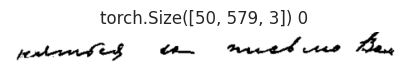

In [ ]:
img, cls = dataset[7]
img = img.permute(1, 2, 0)

plt.figure(figsize=(5, 1))
plt.imshow(img, cmap="grey")
plt.title(f"{img.shape} {cls}")
plt.axis(False)
plt.show()

In [ ]:
cl_model = NetworkStrokes().to(DEVICE).to(DEVICE)
print(f"Parameters number: {number_of_parameters(cl_model)}")

# transform = transforms.ToTensor()
transform = transforms.Compose(
    [
            transforms.ToTensor(),
            Min_size(50),
    ])

dataset = My_Dataset("КККМfolder3_strokes_bin", transform)
print(len(dataset))
train_dataset, test_dataset = split_dataset(dataset)
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

optimizer = torch.optim.Adam(cl_model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)

trainer = Trainer(cl_model, optimizer, criterion, type = "not siam", dir = "logs", name = "strokes_cl3")

trainer.train(train_loader, val_loader, n_epochs = 20)

Parameters number: 205507
1898
split_dataset: Train: 1518 Test: 380 Total: 1898
train dataset: 1518, test dataset: 380


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(f"Device: {DEVICE}")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(DEVICE)
emb_dim = 1000
model = create_model(model, num_freeze_layers=9, num_out_classes=emb_dim).to(DEVICE)
print(f"Parameters number: {number_of_parameters(model)}")

# transform = transforms.ToTensor()
transform = transforms.Compose(
    [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
    ])


dataset = My_TripletDataset("КККМfolder3_bin", transform)
print(len(dataset))
train_dataset, test_dataset = split_dataset(dataset)
print(f"train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.TripletMarginLoss(margin=9, p=2)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainer = Trainer(model, optimizer, criterion, type = "siam", dir = "logs", name = "siam3")

trainer.train(train_loader, val_loader, n_epochs = 30)